In [1]:
%matplotlib inline
import nuwinter
import matplotlib.pyplot as plt
from nuztf.neutrino_scanner import NeutrinoScanner
from astropy import units as u
from nuwinter.avro import load_avro
from nuwinter.plot import ann_fields, generate_single_page
from nuwinter.utils import deduplicate_df
from nuwinter.paths import get_pdf_path
from pathlib import Path
import pandas as pd
import json
from astropy import units as u
from astropy.coordinates import SkyCoord
from matplotlib.colors import Normalize
from matplotlib.ticker import MultipleLocator
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
from tqdm import tqdm
from nuztf.skymap_scanner import SkymapScanner







/Users/robertstein/anaconda3/envs/nuwinter_env/lib/python3.11/site-packages/ligo/lw/lsctables.py:89: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [2]:
base_dir = Path.home().joinpath("Data/winter")

# name = "IC240412A"

name = "S250206dm"

prob_threshold = 0.95
n_days = 14

In [3]:
outpath = str(get_pdf_path(name)).replace("combined", "combined_ztf")
outpath

'/Users/robertstein/Data/nuwinter/S250206dm/winter_candidate_pdf/combined_ztf.pdf'

In [4]:
nu = NeutrinoScanner(name) if "IC" in name else SkymapScanner(
    event=name,
    prob_threshold=prob_threshold,
    n_days=n_days
)

100%|███████████████████████████████████| 1050/1050 [00:00<00:00, 256674.39it/s]


In [5]:
ztf_initial_cache = nu.get_initial_cache_path()

download_ztf = False

if not (ztf_initial_cache.exists()):
    download_ztf = True

if ztf_initial_cache.exists():
    if not ztf_initial_cache.stat().st_size > 2:
        download_ztf = True

if download_ztf:
    print(f"No file found at {ztf_initial_cache}")
    if isinstance(nu, SkymapScanner):
        nu.get_alerts()
        nu.filter_alerts()
    else:
        nu.scan_area(t_max=nu.t_min + 14.)

ztf_initial_cache

PosixPath('/Users/robertstein/Data/nuztf/cache/candidates/S250206dm/rev7/0.95/initial_stage.json')

In [6]:
nights = [str(nu.t_min + (i - 1) * u.day).split("T")[0].replace("-", "") for i in range(n_days + 1)]

all_res = []

for night in sorted(nights):
    
    avro_dir = base_dir / f"{night}/avro"

    print(f"Looking for avros in {avro_dir}")
    
    avro_files = list(avro_dir.glob("*.avro"))
    
    for path in avro_files:
        all_res.append(load_avro(path))

if len(all_res) == 0:
    raise FileNotFoundError(f"No avro files found for any night, please download these first using the download notebook!")

res_winter = pd.concat(all_res)

Looking for avros in /Users/robertstein/Data/winter/20250205/avro
Looking for avros in /Users/robertstein/Data/winter/20250206/avro
Looking for avros in /Users/robertstein/Data/winter/20250207/avro
Looking for avros in /Users/robertstein/Data/winter/20250208/avro
Looking for avros in /Users/robertstein/Data/winter/20250209/avro
Looking for avros in /Users/robertstein/Data/winter/20250210/avro
Looking for avros in /Users/robertstein/Data/winter/20250211/avro
Looking for avros in /Users/robertstein/Data/winter/20250212/avro
Looking for avros in /Users/robertstein/Data/winter/20250213/avro
Looking for avros in /Users/robertstein/Data/winter/20250214/avro
Looking for avros in /Users/robertstein/Data/winter/20250215/avro
Looking for avros in /Users/robertstein/Data/winter/20250216/avro
Looking for avros in /Users/robertstein/Data/winter/20250217/avro
Looking for avros in /Users/robertstein/Data/winter/20250218/avro
Looking for avros in /Users/robertstein/Data/winter/20250219/avro


/var/folders/hd/1411jr114w9cvmmnw9mx0xvr0000gn/T/ipykernel_21614/3059914597.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_winter = pd.concat(all_res)


In [7]:
in_contour = []

for _, row in res_winter.iterrows():
    in_contour.append(nu.in_contour(row["ra"], row["dec"]))

print(f"{np.sum(in_contour)} / {len(in_contour)} candidates in contour")

res_winter = res_winter[in_contour]

34037 / 34070 candidates in contour


In [8]:
res_winter

,objectid,cutout_science,cutout_template,cutout_difference,prv_candidates,candid,deprecated,jd,fid,exptime,...,tmkmag3,tmobjectid3,distgaia,plxgaia,ruwegaia,distgaiabright,plxgaiabright,ruwegaiabright,ztfname,distztf
0,WNTR25azsic,b'\x1f\x8b\x08\x00tb\xa7g\x02\xff\xec\x9bi4\x9...,b'\x1f\x8b\x08\x00tb\xa7g\x02\xff\xec\x9a\xf97...,b'\x1f\x8b\x08\x00tb\xa7g\x02\xff\xec\x97i4\xd...,candid deprecated jd fid ex...,11971332,False,2.460715e+06,2,960.0,...,15.024,02443253+5447502,5.142542,212.397964,0.984985,5.142542,212.397964,0.984985,nan,NaN
1,WNTR25azsid,b'\x1f\x8b\x08\x00ub\xa7g\x02\xff\xec\x97iT\x8...,b'\x1f\x8b\x08\x00ub\xa7g\x02\xff\xec\x9ay4V\x...,b'\x1f\x8b\x08\x00ub\xa7g\x02\xff\xec\x97i4\xd...,candid deprecated jd fid ex...,11971333,False,2.460715e+06,2,960.0,...,NaN,nan,20.335001,0.075740,0.931735,61.678635,78.807297,1.084393,nan,NaN
2,WNTR25azsie,b'\x1f\x8b\x08\x00zb\xa7g\x02\xff\xec\x98i4\x9...,b'\x1f\x8b\x08\x00zb\xa7g\x02\xff\xec\x97\xe97...,b'\x1f\x8b\x08\x00zb\xa7g\x02\xff\xec\xb7i4\x9...,candid deprecated jd fid ex...,11971334,False,2.460715e+06,2,960.0,...,13.273,02433987+5447106,2.855670,1.437257,0.983316,32.827374,78.807297,1.084393,nan,NaN
3,WNTR25azsif,b'\x1f\x8b\x08\x00zb\xa7g\x02\xff\xec\x97\xe97...,b'\x1f\x8b\x08\x00zb\xa7g\x02\xff\xec\x9a\xf9W...,b'\x1f\x8b\x08\x00zb\xa7g\x02\xff\xec\xbaWPUQ\...,candid deprecated jd fid ex...,11971335,False,2.460715e+06,2,960.0,...,14.799,02453115+5446546,5.357937,0.949949,0.998359,75.694580,33.908730,2.294901,nan,NaN
4,WNTR25azsig,b'\x1f\x8b\x08\x00{b\xa7g\x02\xff\xec\x97\xf97...,b'\x1f\x8b\x08\x00{b\xa7g\x02\xff\xec\x97\xf97...,b'\x1f\x8b\x08\x00{b\xa7g\x02\xff\xec\x98y4\xd...,candid deprecated jd fid ex...,11971336,False,2.460715e+06,2,960.0,...,14.021,02435896+5446473,4.981150,138.421722,3.757299,4.981150,138.421722,3.757299,nan,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516,WNTR25bazdb,b'\x1f\x8b\x08\x00\xc0\xaf\xa8g\x02\xff\xec\x9...,b'\x1f\x8b\x08\x00\xc0\xaf\xa8g\x02\xff\xecwi4...,b'\x1f\x8b\x08\x00\xc0\xaf\xa8g\x02\xff\xec\x9...,candid deprecated jd fid ex...,11993787,False,2.460716e+06,2,840.0,...,NaN,nan,15.936575,0.678756,1.040995,NaN,NaN,NaN,nan,NaN
517,WNTR25bazdc,b'\x1f\x8b\x08\x00\xc0\xaf\xa8g\x02\xff\xec\xb...,b'\x1f\x8b\x08\x00\xc0\xaf\xa8g\x02\xff\xec\x9...,b'\x1f\x8b\x08\x00\xc0\xaf\xa8g\x02\xff\xec\xb...,candid deprecated jd fid ex...,11993788,False,2.460716e+06,2,840.0,...,NaN,nan,10.564429,1.519677,0.950814,68.627327,118.739601,1.002982,nan,NaN
518,WNTR25bazdd,b'\x1f\x8b\x08\x00\xc1\xaf\xa8g\x02\xff\xed|yT...,b'\x1f\x8b\x08\x00\xc1\xaf\xa8g\x02\xff\xed\xb...,b'\x1f\x8b\x08\x00\xc1\xaf\xa8g\x02\xff\xec\xb...,candid deprecated jd fid ex...,11993789,False,2.460716e+06,2,840.0,...,15.254,02260723+5329299,9.912482,21.942812,1.005131,83.056053,65.357368,1.054843,nan,NaN
519,WNTR25bazde,b'\x1f\x8b\x08\x00\xc1\xaf\xa8g\x02\xff\xec\x9...,b'\x1f\x8b\x08\x00\xc1\xaf\xa8g\x02\xff\xec\x9...,b'\x1f\x8b\x08\x00\xc1\xaf\xa8g\x02\xff\xec\x9...,candid deprecated jd fid ex...,11993790,False,2.460716e+06,2,840.0,...,NaN,nan,9.223882,3.518126,1.076953,29.619553,27.771591,1.370937,nan,NaN


In [9]:
lims = []

for t in set(res_winter["jd"]):
    for b in set(res_winter["boardid"]):
        mask = (res_winter["jd"] == t) & ((res_winter["boardid"]) == b)
        match = res_winter[mask]
        if len(match) > 0:
            lims.append(match["diffmaglim"][0])

print(f"Found avros from {len(lims)} unique difference images, with median depth of {np.median(lims):.1f} AB mag")

Found avros from 110 unique difference images, with median depth of 18.0 AB mag


In [10]:
with open(ztf_initial_cache, "r") as f:
    res_ztf = json.load(f)
    
ztf_sources = []

for entry in res_ztf:

    new_dict = {}
    
    for field in ["candid", "objectId"]:
        new_dict[field] = entry[field]

    for key, val in entry["candidate"].items():
        new_dict[key] = val

    ztf_sources.append(new_dict)

ztf_df = pd.DataFrame(ztf_sources)
ztf_df

,candid,objectId,jd,fid,pid,diffmaglim,programid,isdiffpos,tblid,nid,...,zpmed,clrmed,clrrms,neargaia,neargaiabright,maggaia,maggaiabright,exptime,drb,drbversion
0,2960202605915015012,ZTF19aadarwk,2.460715e+06,2,2960202605915,20.567062,2,t,12,2960,...,28.843000,0.840,0.199518,0.381248,22.664331,17.351803,13.937666,299.0,0.999949,d6_m7
1,2960144941815015048,ZTF25aaffzet,2.460715e+06,2,2960144941815,20.278807,2,t,48,2960,...,28.726999,0.661,0.300103,11.864977,-999.000000,19.647575,-999.000000,299.0,0.999609,d6_m7
2,2960132431915015006,ZTF25aaffywx,2.460715e+06,1,2960132431915,20.428858,2,t,6,2960,...,28.636999,0.623,0.278374,20.914188,60.137012,19.756334,13.622611,299.0,0.000028,d6_m7
3,2960109132915010035,ZTF25aaffyac,2.460715e+06,2,2960109132915,20.494802,2,f,35,2960,...,28.911499,0.614,0.314109,0.852475,88.296692,15.908446,10.800358,299.0,0.912578,d6_m7
4,2960112714215015003,ZTF25aaffydw,2.460715e+06,2,2960112714215,20.543301,2,t,3,2960,...,28.848000,0.643,0.301168,13.276827,13.276827,12.789435,12.789435,299.0,0.000268,d6_m7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11146,2961261860115015004,ZTF25aafixhh,2.460716e+06,1,2961261860115,20.214075,2,t,4,2961,...,28.573999,0.523,0.156639,3.883622,48.100815,18.089554,12.290076,299.0,0.795999,d6_m7
11147,2961261861015015017,ZTF21abfigbw,2.460716e+06,1,2961261861015,19.910294,2,t,17,2961,...,28.559999,0.546,0.176362,0.352780,23.099375,15.185712,12.706429,299.0,0.754447,d6_m7
11148,2961261862315010045,ZTF25aafixks,2.460716e+06,1,2961261862315,20.130819,2,f,45,2961,...,28.607000,0.540,0.166603,0.648002,31.430960,15.594314,12.452973,299.0,0.653679,d6_m7
11149,2961261864115015017,ZTF20abedkkb,2.460716e+06,1,2961261864115,20.128227,2,t,17,2961,...,28.610001,0.552,0.145382,0.807681,67.826599,15.148433,13.431901,299.0,0.842173,d6_m7


In [11]:
ztf_df

,candid,objectId,jd,fid,pid,diffmaglim,programid,isdiffpos,tblid,nid,...,zpmed,clrmed,clrrms,neargaia,neargaiabright,maggaia,maggaiabright,exptime,drb,drbversion
0,2960202605915015012,ZTF19aadarwk,2.460715e+06,2,2960202605915,20.567062,2,t,12,2960,...,28.843000,0.840,0.199518,0.381248,22.664331,17.351803,13.937666,299.0,0.999949,d6_m7
1,2960144941815015048,ZTF25aaffzet,2.460715e+06,2,2960144941815,20.278807,2,t,48,2960,...,28.726999,0.661,0.300103,11.864977,-999.000000,19.647575,-999.000000,299.0,0.999609,d6_m7
2,2960132431915015006,ZTF25aaffywx,2.460715e+06,1,2960132431915,20.428858,2,t,6,2960,...,28.636999,0.623,0.278374,20.914188,60.137012,19.756334,13.622611,299.0,0.000028,d6_m7
3,2960109132915010035,ZTF25aaffyac,2.460715e+06,2,2960109132915,20.494802,2,f,35,2960,...,28.911499,0.614,0.314109,0.852475,88.296692,15.908446,10.800358,299.0,0.912578,d6_m7
4,2960112714215015003,ZTF25aaffydw,2.460715e+06,2,2960112714215,20.543301,2,t,3,2960,...,28.848000,0.643,0.301168,13.276827,13.276827,12.789435,12.789435,299.0,0.000268,d6_m7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11146,2961261860115015004,ZTF25aafixhh,2.460716e+06,1,2961261860115,20.214075,2,t,4,2961,...,28.573999,0.523,0.156639,3.883622,48.100815,18.089554,12.290076,299.0,0.795999,d6_m7
11147,2961261861015015017,ZTF21abfigbw,2.460716e+06,1,2961261861015,19.910294,2,t,17,2961,...,28.559999,0.546,0.176362,0.352780,23.099375,15.185712,12.706429,299.0,0.754447,d6_m7
11148,2961261862315010045,ZTF25aafixks,2.460716e+06,1,2961261862315,20.130819,2,f,45,2961,...,28.607000,0.540,0.166603,0.648002,31.430960,15.594314,12.452973,299.0,0.653679,d6_m7
11149,2961261864115015017,ZTF20abedkkb,2.460716e+06,1,2961261864115,20.128227,2,t,17,2961,...,28.610001,0.552,0.145382,0.807681,67.826599,15.148433,13.431901,299.0,0.842173,d6_m7


In [12]:
if len(ztf_df) > 0:
    ztf_positions = SkyCoord(ztf_df["ra"].to_numpy()*u.deg, ztf_df["dec"].to_numpy()*u.deg, frame='icrs')
    
    winter_positions = SkyCoord(res_winter["ra"].to_numpy()*u.deg, res_winter["dec"].to_numpy()*u.deg, frame='icrs')
    idx, d2d, _ = winter_positions.match_to_catalog_sky(ztf_positions)
    
    crossmatch_radius = 3.0 * u.arcsec
    mask = d2d < crossmatch_radius
    
    cut = res_winter[mask]
    cut.reset_index(inplace=True)
    cut

In [13]:
if len(ztf_df) > 0:
    ztf_names = []

    for i in idx[mask]:
        ztf_names.append(ztf_df["objectId"].iloc[i])
    
    cut = cut.assign(ztf_name=ztf_names)
    if len(cut) > 0:
        cut = deduplicate_df(cut)
    cut
else:
    cut = pd.DataFrame()

In [14]:
if len(cut) > 0:
    outpath = str(get_pdf_path(name)).replace("combined", "combined_ztf")
    
    print(f"Saving PDF to {outpath}")
    
    with PdfPages(outpath) as pdf:
        for i, row in tqdm(cut.iterrows(), total=len(cut)):
            generate_single_page(row, ann_fields=["ztf_name"] + ann_fields)
            pdf.savefig()
            plt.close()

    outpath = str(get_pdf_path(name)).replace("combined", "combined_ztf_crossmatched")

    with PdfPages(outpath) as pdf:
        for i, row in tqdm(cut.iterrows(), total=len(cut)):
            generate_single_page(row, ann_fields=["ztf_name"] + ann_fields, crossmatch=True)
            pdf.savefig()
            plt.close()
else:
    print("No candidates found")

Saving PDF to /Users/robertstein/Data/nuwinter/S250206dm/winter_candidate_pdf/combined_ztf.pdf


100%|███████████████████████████████████████████| 52/52 [01:18<00:00,  1.51s/it]


In [15]:
len(res_winter["objectid"])

34037

In [16]:
# crossmatch_radius = 2.0 * u.arcsec

# winter_positions = SkyCoord(res_winter["ra"].to_numpy()*u.deg, res_winter["dec"].to_numpy()*u.deg, frame='icrs')


# match = []

# for i, c in enumerate(winter_positions):
#     if i < len(winter_positions) - 1:
#         idx, d2d, _ = c.match_to_catalog_sky(winter_positions[i+1:])
#         if d2d < crossmatch_radius:
#             match.append(idx)
#         else:
#             match.append(None)
#     else:
#         match.append(None)

In [17]:
# res_winter["match"] = match
# res_winter_match = res_winter[pd.notnull(match)]
res_winter_match = res_winter

In [18]:
# all_matched = []

# for i, row in res_winter_match.iterrows():
#     c = SkyCoord(row["ra"]*u.deg, row["dec"]*u.deg, frame='icrs')
#     sep = c.separation(winter_positions)
#     mask = (sep.arcsec > 0.) & (sep.arcsec < crossmatch_radius.value)
#     matches = res_winter.loc[mask]
#     row["ndethist"] = mask.sum()
#     row["prv_candidates"] = res_winter.loc[mask]
#     print(row["objectid"], res_winter.loc[mask]["objectid"])
#     all_matched.append(row)

# if len(all_matched) > 0:
#     res_winter_match = pd.concat(all_matched, axis=1).transpose()
#     res_winter_match

In [19]:
sgscore_cut = 0.5
dist_cut_arcsec = 5.

star_cut = (pd.notnull(res_winter_match["distpsnr1"]) & (res_winter_match["distpsnr1"] < dist_cut_arcsec) & pd.notnull(res_winter_match["sgscore1"]) & (res_winter_match["sgscore1"] > sgscore_cut))

masks = [
    res_winter_match["ndethist"] > 0,
    ~star_cut,
    res_winter_match["nbad"] < 2,
    res_winter_match["chipsf"] < 3.0,
    res_winter_match["sumrat"] > 0.7,
    res_winter_match["fwhm"] < 10.0,
    res_winter_match["magdiff"] < 1.6,
    res_winter_match["magdiff"] > -1.0,
    res_winter_match["mindtoedge"] > 50.0,
]

mask = np.ones(len(res_winter_match), dtype=bool)
for new_mask in masks:
    mask *= new_mask
    
print(f"{np.sum(mask)} / {len(mask)} detections pass all cuts")
cut2 = res_winter_match[mask]

if len(cut2) > 0:
    cut2 = deduplicate_df(cut2)
    cut2.sort_values(by="objectid", inplace=True)
    
    outpath = str(get_pdf_path(name)).replace("combined", "combined_2dets")
    print(f"Saving PDF to {outpath}")
    
    with PdfPages(outpath) as pdf:
        for i, row in tqdm(cut2.iterrows(), total=len(cut2)):
            generate_single_page(row, ann_fields=ann_fields, crossmatch=False)
            pdf.savefig()
            plt.close()

    outpath = str(get_pdf_path(name)).replace("combined", "combined_2dets_crossmatched")
    print(f"Saving PDF to {outpath}")
    
    with PdfPages(outpath) as pdf:
        for i, row in tqdm(cut2.iterrows(), total=len(cut2)):
            generate_single_page(row, ann_fields=ann_fields, crossmatch=True)
            pdf.savefig()
            plt.close()

3 / 34037 detections pass all cuts
Saving PDF to /Users/robertstein/Data/nuwinter/S250206dm/winter_candidate_pdf/combined_2dets.pdf


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 17.55it/s]


Saving PDF to /Users/robertstein/Data/nuwinter/S250206dm/winter_candidate_pdf/combined_2dets_crossmatched.pdf


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.61it/s]


In [20]:
list(res_winter_match.columns)

['objectid',
 'cutout_science',
 'cutout_template',
 'cutout_difference',
 'prv_candidates',
 'candid',
 'deprecated',
 'jd',
 'fid',
 'exptime',
 'ndethist',
 'jdstarthist',
 'jdendhist',
 'progname',
 'programid',
 'isdiffpos',
 'fieldid',
 'boardid',
 'ra',
 'dec',
 'magzpsci',
 'magzpsciunc',
 'magzpscirms',
 'diffmaglim',
 'magpsf',
 'sigmapsf',
 'chipsf',
 'magap',
 'sigmagap',
 'magapbig',
 'sigmagapbig',
 'magdiff',
 'magfromlim',
 'distnr',
 'magnr',
 'sigmagnr',
 'xpos',
 'ypos',
 'sky',
 'fwhm',
 'classtar',
 'mindtoedge',
 'seeratio',
 'aimage',
 'bimage',
 'aimagerat',
 'bimagerat',
 'elong',
 'nneg',
 'nbad',
 'sumrat',
 'dsnrms',
 'ssnrms',
 'dsdiff',
 'scorr',
 'clrcoeff',
 'clrcounc',
 'zpclrcov',
 'zpmed',
 'clrmed',
 'clrrms',
 'rb',
 'rbversion',
 'ssdistnr',
 'ssmagnr',
 'ssnamenr',
 'tooflag',
 'nmtchps',
 'psra1',
 'psdec1',
 'psobjectid1',
 'sgmag1',
 'srmag1',
 'simag1',
 'szmag1',
 'sgscore1',
 'distpsnr1',
 'ps1class1',
 'ps1probstar1',
 'ps1probqso1',
 'ps1p

In [21]:
# Download the TNS after JSON for GW event, 

tns_dir = get_pdf_path(name).parent.parent

print(f"Looking for TNS json in {tns_dir}")

tns_blob = list(tns_dir.glob("*.json"))

tns_df = pd.read_json(tns_blob[0]).transpose() if len(tns_blob) > 0 else pd.DataFrame()
tns_df

Looking for TNS json in /Users/robertstein/Data/nuwinter/S250206dm


,name_prefix,name,ra,declination,type,source_group,discoverymag,filter,discoverydate,credibility_level,within_region
2025bcc,AT,2025bcc,32.0290163368,55.3424808365,None,Pan-STARRS,19.57,r,2025-02-08 07:56:15.936,0.879,90.0%
2025bbt,AT,2025bbt,45.4690744083,51.1297339492,None,Pan-STARRS,18.64,r,2025-02-08 07:37:12.864,0.879,90.0%
2025bbo,AT,2025bbo,24.321968197,45.7255036462,None,Pan-STARRS,20.05,r,2025-02-08 06:52:58.656,0.859,90.0%
2025bbn,AT,2025bbn,37.7884406955,50.7353306689,None,Pan-STARRS,20.19,r,2025-02-08 06:11:59.712,0.519,90.0%
2025bbm,AT,2025bbm,36.9626528358,49.4759078245,None,Pan-STARRS,20.03,r,2025-02-08 06:11:59.712,0.724,90.0%
2025bay,AT,2025bay,7.50487405736,37.1683245958,None,ZTF,20.5136,r,2025-02-08 03:18:17.997,0.686,90.0%
2025bau,AT,2025bau,253.166158,-66.813549,None,GOTO,19.59,L,2025-02-07 18:07:51.744,0.73,90.0%
2025azn,AT,2025azn,39.822573,49.572528,None,SAGUARO,19.9659,Clear,2025-02-07 04:44:57.000,0.868,90.0%
2025azm,AT,2025azm,2.031278,32.56575,None,SAGUARO,20.1015,Clear,2025-02-07 04:44:57.000,0.768,90.0%
2025bci,AT,2025bci,151.739711737,-22.1493082623,None,Pan-STARRS,20.38,r,2025-02-08 10:26:34.368,0.965,99.0%


In [22]:
if len(tns_df) > 0:
    tns_positions = SkyCoord(tns_df["ra"].to_numpy(dtype=float)*u.deg, tns_df["declination"].to_numpy(dtype=float)*u.deg, frame='icrs')
    
    winter_positions = SkyCoord(res_winter["ra"].to_numpy()*u.deg, res_winter["dec"].to_numpy()*u.deg, frame='icrs')
    idx, d2d, _ = winter_positions.match_to_catalog_sky(tns_positions)
    
    crossmatch_radius = 3.0 * u.arcsec
    mask = d2d < crossmatch_radius

    print(f"Found {mask.sum()}/{len(winter_positions)} matches to {len(tns_df)} TNS sources.")

    cut_tns = res_winter.copy()

Found 0/34037 matches to 35 TNS sources.


In [23]:
cut_tns

,objectid,cutout_science,cutout_template,cutout_difference,prv_candidates,candid,deprecated,jd,fid,exptime,...,tmkmag3,tmobjectid3,distgaia,plxgaia,ruwegaia,distgaiabright,plxgaiabright,ruwegaiabright,ztfname,distztf
0,WNTR25azsic,b'\x1f\x8b\x08\x00tb\xa7g\x02\xff\xec\x9bi4\x9...,b'\x1f\x8b\x08\x00tb\xa7g\x02\xff\xec\x9a\xf97...,b'\x1f\x8b\x08\x00tb\xa7g\x02\xff\xec\x97i4\xd...,candid deprecated jd fid ex...,11971332,False,2.460715e+06,2,960.0,...,15.024,02443253+5447502,5.142542,212.397964,0.984985,5.142542,212.397964,0.984985,nan,NaN
1,WNTR25azsid,b'\x1f\x8b\x08\x00ub\xa7g\x02\xff\xec\x97iT\x8...,b'\x1f\x8b\x08\x00ub\xa7g\x02\xff\xec\x9ay4V\x...,b'\x1f\x8b\x08\x00ub\xa7g\x02\xff\xec\x97i4\xd...,candid deprecated jd fid ex...,11971333,False,2.460715e+06,2,960.0,...,NaN,nan,20.335001,0.075740,0.931735,61.678635,78.807297,1.084393,nan,NaN
2,WNTR25azsie,b'\x1f\x8b\x08\x00zb\xa7g\x02\xff\xec\x98i4\x9...,b'\x1f\x8b\x08\x00zb\xa7g\x02\xff\xec\x97\xe97...,b'\x1f\x8b\x08\x00zb\xa7g\x02\xff\xec\xb7i4\x9...,candid deprecated jd fid ex...,11971334,False,2.460715e+06,2,960.0,...,13.273,02433987+5447106,2.855670,1.437257,0.983316,32.827374,78.807297,1.084393,nan,NaN
3,WNTR25azsif,b'\x1f\x8b\x08\x00zb\xa7g\x02\xff\xec\x97\xe97...,b'\x1f\x8b\x08\x00zb\xa7g\x02\xff\xec\x9a\xf9W...,b'\x1f\x8b\x08\x00zb\xa7g\x02\xff\xec\xbaWPUQ\...,candid deprecated jd fid ex...,11971335,False,2.460715e+06,2,960.0,...,14.799,02453115+5446546,5.357937,0.949949,0.998359,75.694580,33.908730,2.294901,nan,NaN
4,WNTR25azsig,b'\x1f\x8b\x08\x00{b\xa7g\x02\xff\xec\x97\xf97...,b'\x1f\x8b\x08\x00{b\xa7g\x02\xff\xec\x97\xf97...,b'\x1f\x8b\x08\x00{b\xa7g\x02\xff\xec\x98y4\xd...,candid deprecated jd fid ex...,11971336,False,2.460715e+06,2,960.0,...,14.021,02435896+5446473,4.981150,138.421722,3.757299,4.981150,138.421722,3.757299,nan,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516,WNTR25bazdb,b'\x1f\x8b\x08\x00\xc0\xaf\xa8g\x02\xff\xec\x9...,b'\x1f\x8b\x08\x00\xc0\xaf\xa8g\x02\xff\xecwi4...,b'\x1f\x8b\x08\x00\xc0\xaf\xa8g\x02\xff\xec\x9...,candid deprecated jd fid ex...,11993787,False,2.460716e+06,2,840.0,...,NaN,nan,15.936575,0.678756,1.040995,NaN,NaN,NaN,nan,NaN
517,WNTR25bazdc,b'\x1f\x8b\x08\x00\xc0\xaf\xa8g\x02\xff\xec\xb...,b'\x1f\x8b\x08\x00\xc0\xaf\xa8g\x02\xff\xec\x9...,b'\x1f\x8b\x08\x00\xc0\xaf\xa8g\x02\xff\xec\xb...,candid deprecated jd fid ex...,11993788,False,2.460716e+06,2,840.0,...,NaN,nan,10.564429,1.519677,0.950814,68.627327,118.739601,1.002982,nan,NaN
518,WNTR25bazdd,b'\x1f\x8b\x08\x00\xc1\xaf\xa8g\x02\xff\xed|yT...,b'\x1f\x8b\x08\x00\xc1\xaf\xa8g\x02\xff\xed\xb...,b'\x1f\x8b\x08\x00\xc1\xaf\xa8g\x02\xff\xec\xb...,candid deprecated jd fid ex...,11993789,False,2.460716e+06,2,840.0,...,15.254,02260723+5329299,9.912482,21.942812,1.005131,83.056053,65.357368,1.054843,nan,NaN
519,WNTR25bazde,b'\x1f\x8b\x08\x00\xc1\xaf\xa8g\x02\xff\xec\x9...,b'\x1f\x8b\x08\x00\xc1\xaf\xa8g\x02\xff\xec\x9...,b'\x1f\x8b\x08\x00\xc1\xaf\xa8g\x02\xff\xec\x9...,candid deprecated jd fid ex...,11993790,False,2.460716e+06,2,840.0,...,NaN,nan,9.223882,3.518126,1.076953,29.619553,27.771591,1.370937,nan,NaN


Saving PDF to /Users/robertstein/Data/nuwinter/S250206dm/winter_candidate_pdf/combined_tns.pdf


  0%|                                                 | 0/34037 [00:00<?, ?it/s]
/var/folders/hd/1411jr114w9cvmmnw9mx0xvr0000gn/T/ipykernel_21614/2596185165.py:6: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 3.8 and support will be removed two minor releases later.
  with PdfPages(outpath) as pdf:


KeyError: 'ztf_name'

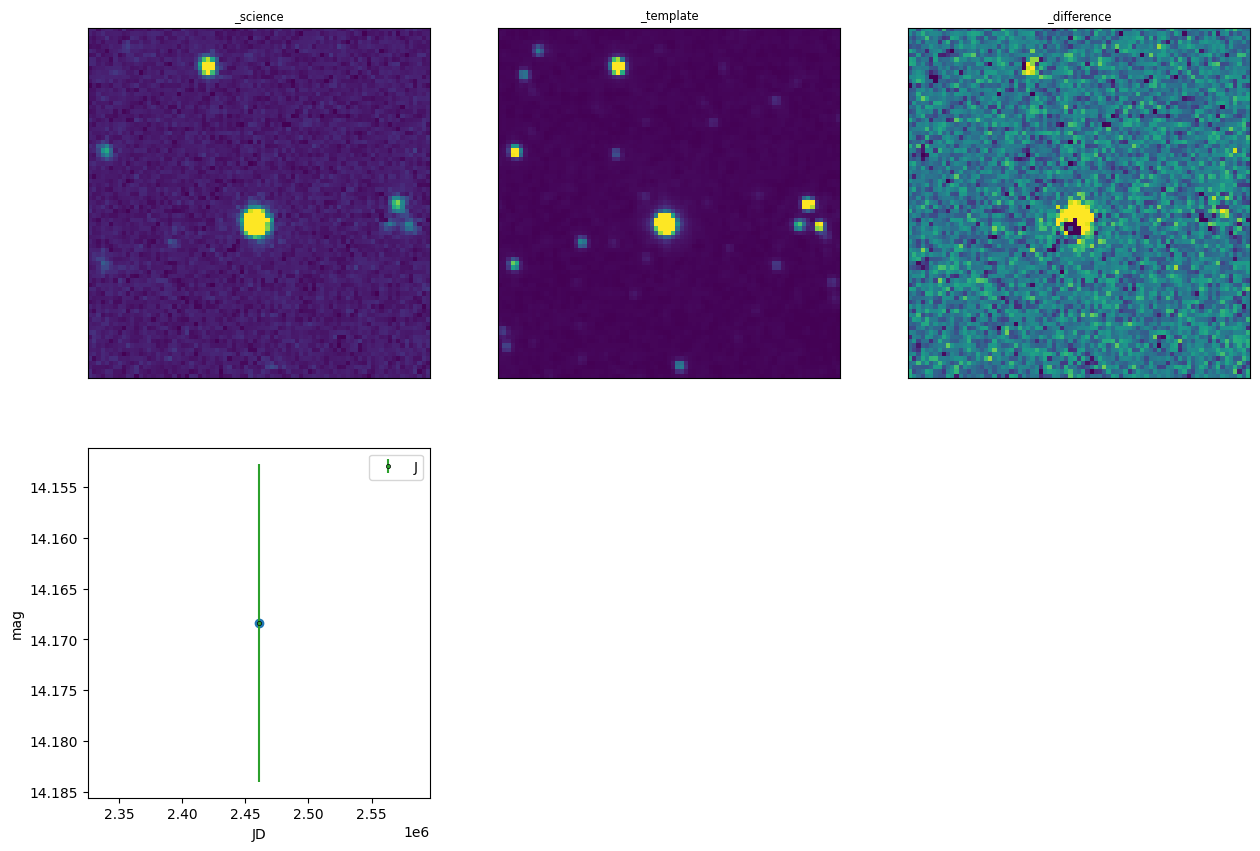

In [24]:
if len(cut_tns) > 0:
    outpath = str(get_pdf_path(name)).replace("combined", "combined_tns")
    
    print(f"Saving PDF to {outpath}")
    
    with PdfPages(outpath) as pdf:
        for i, row in tqdm(cut_tns.iterrows(), total=len(cut)):
            generate_single_page(row, ann_fields=["ztf_name"] + ann_fields)
            pdf.savefig()
            plt.close()

    outpath = str(get_pdf_path(name)).replace("combined", "combined_ztf_crossmatched")

    with PdfPages(outpath) as pdf:
        for i, row in tqdm(cut_tns.iterrows(), total=len(cut)):
            generate_single_page(row, ann_fields=["ztf_name"] + ann_fields, crossmatch=True)
            pdf.savefig()
            plt.close()
else:
    print("No candidates found")